# Marketing Analytics: MMM and MTA

## Educational Demo Notebook

This notebook provides hands-on demonstrations of two key marketing analytics methodologies:

1. **Marketing Mix Modeling (MMM)** - A top-down approach to measure the impact of marketing channels on sales
2. **Multi-Touch Attribution (MTA)** - A bottom-up approach to credit individual touchpoints in the customer journey

---

## Setup: Import Required Libraries

First, let's import all the libraries we'll need for our analysis.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


---

# Part 1: Marketing Mix Modeling (MMM)

## What is Marketing Mix Modeling?

**Marketing Mix Modeling (MMM)** is a statistical analysis technique that helps quantify the impact of various marketing activities on sales or other KPIs. It uses **aggregate data** (weekly or monthly) to understand:

- How much each marketing channel contributes to sales
- The ROI of different marketing investments
- Optimal budget allocation across channels

### Key Characteristics:
- **Top-down approach**: Analyzes aggregate data
- **Privacy-friendly**: No individual user tracking needed
- **Includes offline channels**: TV, radio, print ads
- **Accounts for external factors**: Seasonality, promotions, economic conditions

---

## Step 1: Generate Synthetic Marketing Data

Let's create a realistic dataset representing 2 years of weekly marketing data for a company using multiple channels.

In [3]:
# Set random seed for reproducibility
np.random.seed(42)

# Generate 104 weeks (2 years) of data
n_weeks = 104

# Create date range
dates = pd.date_range(start='2023-01-01', periods=n_weeks, freq='W')

# Generate marketing spend data (in thousands of dollars)
tv_spend = np.random.uniform(20, 80, n_weeks)
digital_spend = np.random.uniform(10, 50, n_weeks)
social_spend = np.random.uniform(5, 30, n_weeks)
search_spend = np.random.uniform(8, 40, n_weeks)

# Add seasonality factor (higher in Q4)
seasonality = 1 + 0.3 * np.sin(2 * np.pi * np.arange(n_weeks) / 52 - np.pi/2)

# Generate sales with realistic relationships to marketing spend
# Sales = Base + (Channel Effects) + Seasonality + Noise
base_sales = 500
sales = (base_sales + 
         2.5 * tv_spend +           # TV has strong impact
         3.0 * digital_spend +      # Digital has strongest impact
         1.8 * social_spend +       # Social has moderate impact
         2.2 * search_spend +       # Search has good impact
         100 * seasonality +        # Seasonal effect
         np.random.normal(0, 50, n_weeks))  # Random noise

# Create DataFrame
mmm_data = pd.DataFrame({
    'date': dates,
    'tv_spend': tv_spend,
    'digital_spend': digital_spend,
    'social_spend': social_spend,
    'search_spend': search_spend,
    'seasonality': seasonality,
    'sales': sales
})

print(f"Dataset created with {n_weeks} weeks of data")
print(f"\nFirst few rows:")
mmm_data.head()

Dataset created with 104 weeks of data

First few rows:


,date,tv_spend,digital_spend,social_spend,search_spend,seasonality,sales
0,2023-01-01,42.472407,46.302659,5.126540,8.811224,0.700000,793.400589
1,2023-01-08,77.042858,19.971689,9.020201,38.804749,0.702187,863.638327
2,2023-01-15,63.919637,26.415317,18.718345,34.751364,0.708717,977.968352
3,2023-01-22,55.919509,40.222046,22.297380,30.271175,0.719495,978.729425
4,2023-01-29,29.361118,19.151927,21.299031,21.086494,0.734363,820.229430


## Step 2: Explore the Data

Let's visualize the marketing spend and sales over time to understand patterns.

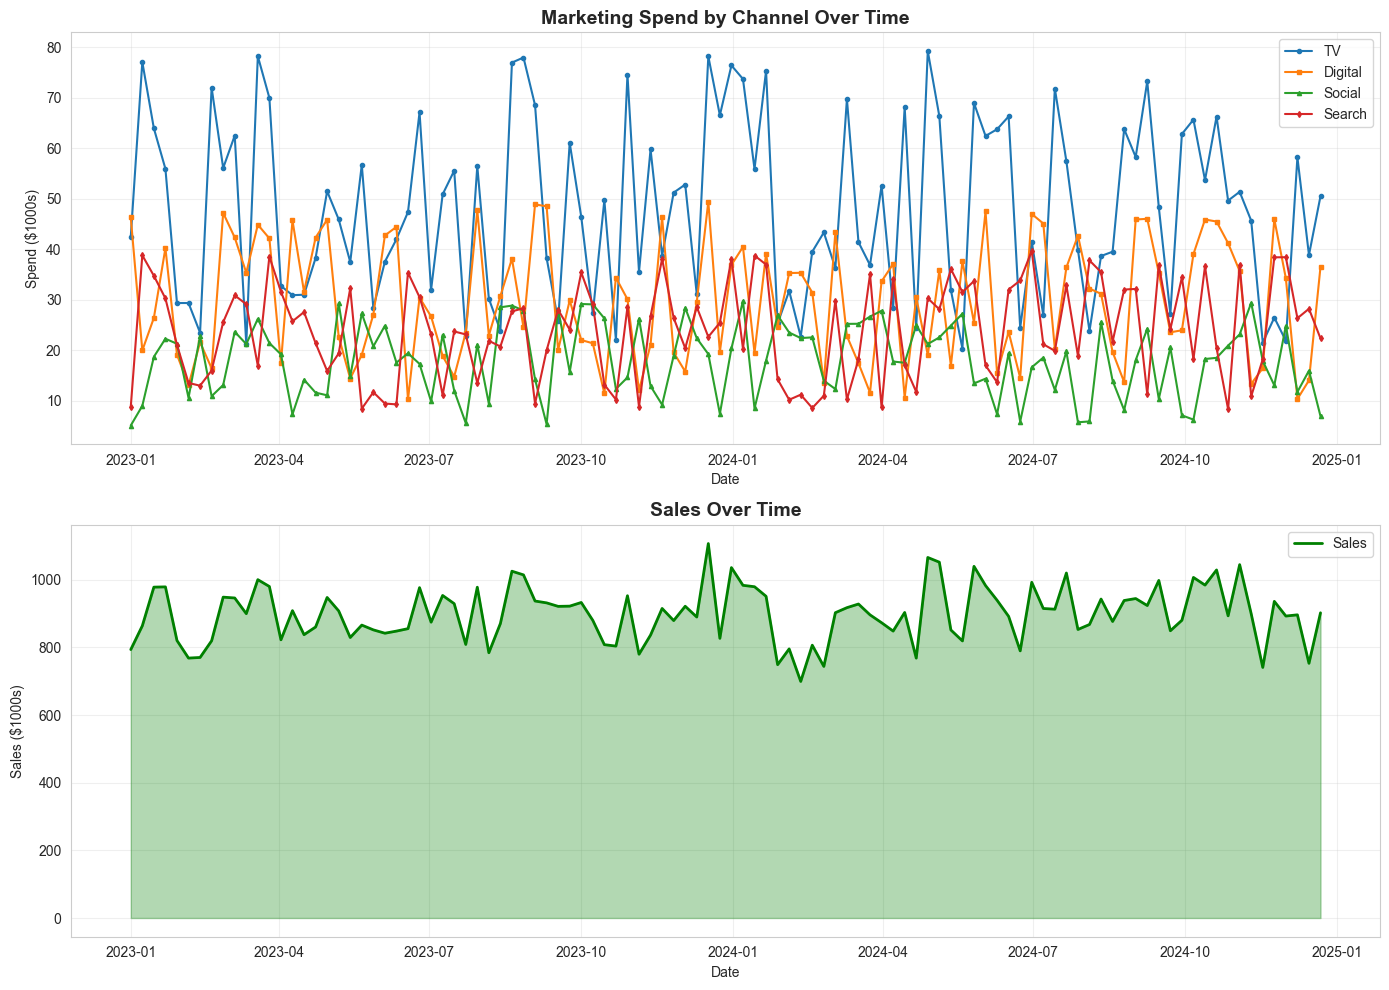


Summary Statistics:
       tv_spend  digital_spend  social_spend  search_spend    sales
count    104.00         104.00        104.00        104.00   104.00
mean      47.99          29.79         18.10         24.02   898.96
std       17.74          11.91          7.16          9.64    82.26
min       20.33          10.28          5.13          8.35   699.22
25%       31.59          19.56         12.30         15.99   846.44
50%       47.85          30.27         18.64         24.13   900.83
75%       63.75          40.65         23.81         32.06   949.01
max       79.21          49.43         29.75         39.70  1106.76


In [4]:
# Create visualizations
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Marketing Spend Over Time
axes[0].plot(mmm_data['date'], mmm_data['tv_spend'], label='TV', marker='o', markersize=3)
axes[0].plot(mmm_data['date'], mmm_data['digital_spend'], label='Digital', marker='s', markersize=3)
axes[0].plot(mmm_data['date'], mmm_data['social_spend'], label='Social', marker='^', markersize=3)
axes[0].plot(mmm_data['date'], mmm_data['search_spend'], label='Search', marker='d', markersize=3)
axes[0].set_title('Marketing Spend by Channel Over Time', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Spend ($1000s)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Sales Over Time
axes[1].plot(mmm_data['date'], mmm_data['sales'], color='green', linewidth=2, label='Sales')
axes[1].fill_between(mmm_data['date'], mmm_data['sales'], alpha=0.3, color='green')
axes[1].set_title('Sales Over Time', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Sales ($1000s)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\nSummary Statistics:")
print(mmm_data[['tv_spend', 'digital_spend', 'social_spend', 'search_spend', 'sales']].describe().round(2))

## Step 3: Build the Marketing Mix Model

We'll use **linear regression** to model the relationship between marketing spend and sales.

The model equation is:

$$\text{Sales} = \beta_0 + \beta_1 \times \text{TV} + \beta_2 \times \text{Digital} + \beta_3 \times \text{Social} + \beta_4 \times \text{Search} + \beta_5 \times \text{Seasonality} + \epsilon$$

Where:
- $\beta_0$ = Base sales (intercept)
- $\beta_1, \beta_2, \beta_3, \beta_4$ = Channel coefficients (impact per dollar spent)
- $\beta_5$ = Seasonality effect
- $\epsilon$ = Error term

In [5]:
# Prepare features (X) and target (y)
X = mmm_data[['tv_spend', 'digital_spend', 'social_spend', 'search_spend', 'seasonality']]
y = mmm_data['sales']

# Build the model
mmm_model = LinearRegression()
mmm_model.fit(X, y)

# Make predictions
y_pred = mmm_model.predict(X)

# Calculate model performance
r2 = r2_score(y, y_pred)
mae = mean_absolute_error(y, y_pred)

print("=" * 60)
print("MARKETING MIX MODEL RESULTS")
print("=" * 60)
print(f"\nModel Performance:")
print(f"  R² Score: {r2:.4f} (explains {r2*100:.2f}% of variance in sales)")
print(f"  Mean Absolute Error: ${mae:.2f}k")
print(f"\nBase Sales (Intercept): ${mmm_model.intercept_:.2f}k")
print(f"\nChannel Coefficients (Sales impact per $1k spent):")
print(f"  TV:      ${mmm_model.coef_[0]:.2f}k")
print(f"  Digital: ${mmm_model.coef_[1]:.2f}k")
print(f"  Social:  ${mmm_model.coef_[2]:.2f}k")
print(f"  Search:  ${mmm_model.coef_[3]:.2f}k")
print(f"\nSeasonality Effect: ${mmm_model.coef_[4]:.2f}k")
print("=" * 60)

MARKETING MIX MODEL RESULTS

Model Performance:
  R² Score: 0.7091 (explains 70.91% of variance in sales)
  Mean Absolute Error: $36.18k

Base Sales (Intercept): $516.67k

Channel Coefficients (Sales impact per $1k spent):
  TV:      $2.82k
  Digital: $2.37k
  Social:  $2.13k
  Search:  $3.06k

Seasonality Effect: $64.53k


## Step 4: Visualize Model Fit

Let's compare actual sales vs. predicted sales to see how well our model performs.

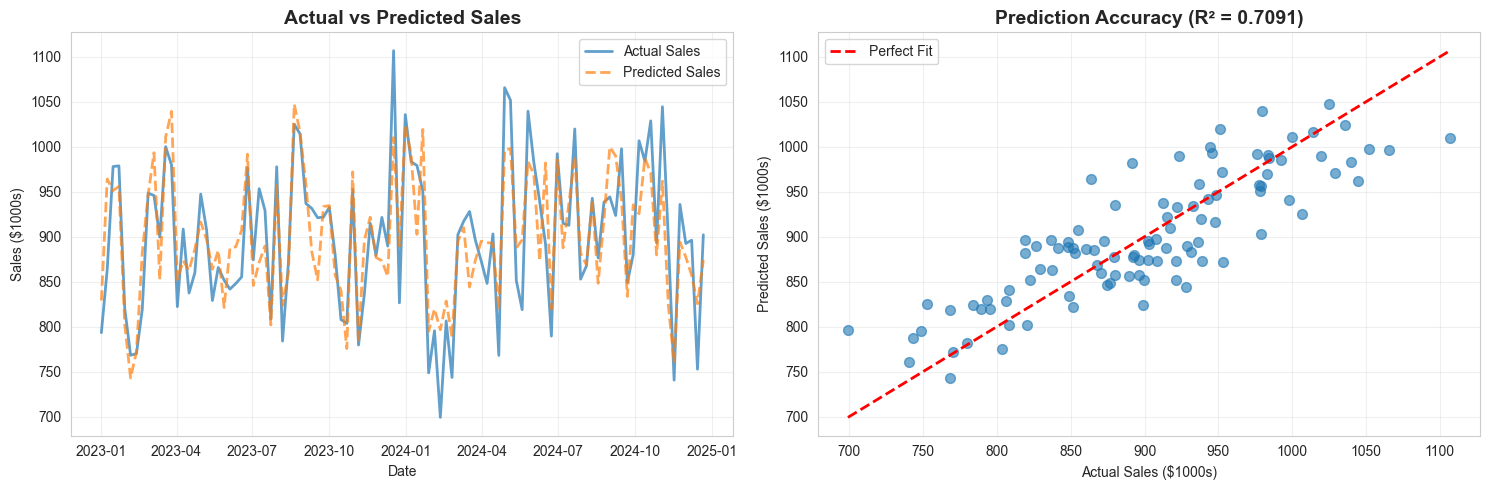

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Actual vs Predicted Sales Over Time
axes[0].plot(mmm_data['date'], y, label='Actual Sales', linewidth=2, alpha=0.7)
axes[0].plot(mmm_data['date'], y_pred, label='Predicted Sales', linewidth=2, alpha=0.7, linestyle='--')
axes[0].set_title('Actual vs Predicted Sales', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Sales ($1000s)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Scatter Plot (Actual vs Predicted)
axes[1].scatter(y, y_pred, alpha=0.6, s=50)
axes[1].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='Perfect Fit')
axes[1].set_title(f'Prediction Accuracy (R² = {r2:.4f})', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Actual Sales ($1000s)')
axes[1].set_ylabel('Predicted Sales ($1000s)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 5: Calculate Channel Contribution and ROI

Now let's calculate how much each channel contributes to total sales and the ROI for each channel.


Channel Performance Analysis:
Channel  Total Spend ($k)  Sales Contribution ($k)      ROI    ROI (%)
 Search       2497.680545              7633.310605 2.056160 205.615969
     TV       4990.530436             14055.633884 1.816461 181.646091
Digital       3098.374399              7348.376302 1.371688 137.168765
 Social       1881.973175              4009.536213 1.130496 113.049594


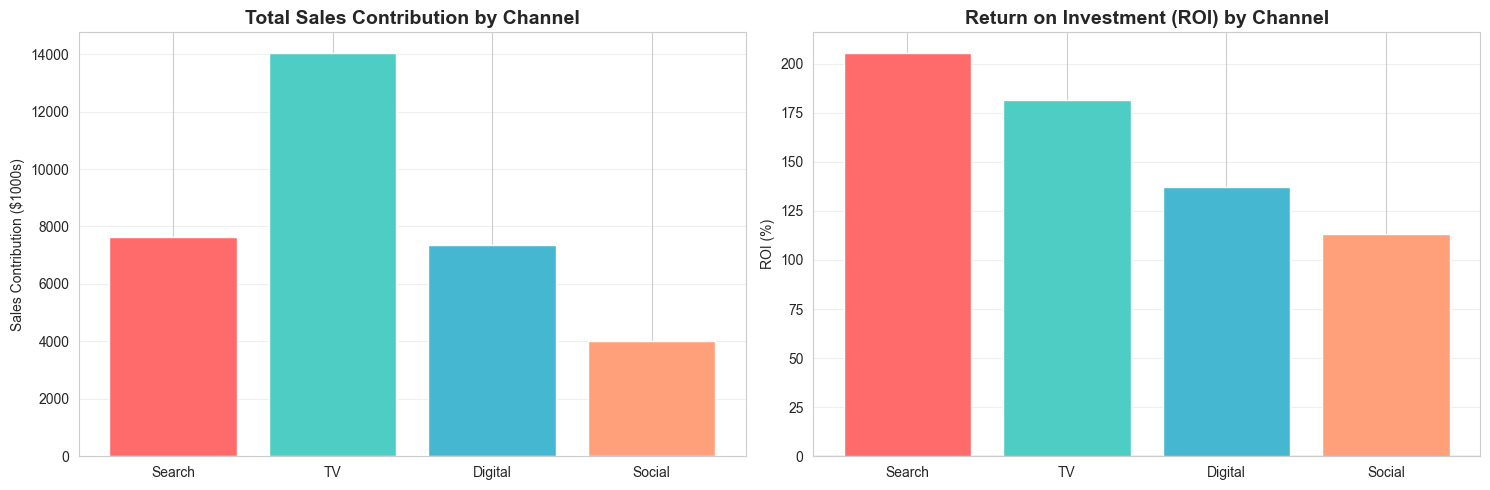

In [7]:
# Calculate total contribution by channel
channels = ['TV', 'Digital', 'Social', 'Search']
spend_cols = ['tv_spend', 'digital_spend', 'social_spend', 'search_spend']

contributions = []
total_spend = []
roi_values = []

for i, channel in enumerate(channels):
    # Total contribution = coefficient × total spend
    contrib = mmm_model.coef_[i] * mmm_data[spend_cols[i]].sum()
    contributions.append(contrib)
    
    # Total spend
    spend = mmm_data[spend_cols[i]].sum()
    total_spend.append(spend)
    
    # ROI = (Revenue - Spend) / Spend
    roi = (contrib - spend) / spend
    roi_values.append(roi)

# Create results DataFrame
channel_results = pd.DataFrame({
    'Channel': channels,
    'Total Spend ($k)': total_spend,
    'Sales Contribution ($k)': contributions,
    'ROI': roi_values,
    'ROI (%)': [roi * 100 for roi in roi_values]
})

channel_results = channel_results.sort_values('ROI', ascending=False)

print("\nChannel Performance Analysis:")
print(channel_results.to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Sales Contribution by Channel
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
axes[0].bar(channel_results['Channel'], channel_results['Sales Contribution ($k)'], color=colors)
axes[0].set_title('Total Sales Contribution by Channel', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Sales Contribution ($1000s)')
axes[0].grid(True, alpha=0.3, axis='y')

# Plot 2: ROI by Channel
axes[1].bar(channel_results['Channel'], channel_results['ROI (%)'], color=colors)
axes[1].set_title('Return on Investment (ROI) by Channel', fontsize=14, fontweight='bold')
axes[1].set_ylabel('ROI (%)')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Step 6: Budget Optimization Simulation

Let's simulate what happens if we reallocate budget to the highest-performing channels.

In [8]:
# Current total marketing budget
current_budget = mmm_data[spend_cols].sum().sum()
current_sales = y.sum()

print(f"Current Scenario:")
print(f"  Total Marketing Budget: ${current_budget:.2f}k")
print(f"  Total Sales: ${current_sales:.2f}k")
print(f"  Overall Marketing ROI: {((current_sales - current_budget) / current_budget * 100):.2f}%")

# Optimized scenario: Allocate budget proportionally to ROI
# (In reality, this would need diminishing returns consideration)
print(f"\n{'='*60}")
print("BUDGET OPTIMIZATION INSIGHT")
print(f"{'='*60}")
print(f"\nBased on the ROI analysis:")
print(f"  - {channel_results.iloc[0]['Channel']} has the highest ROI ({channel_results.iloc[0]['ROI (%)']:.2f}%)")
print(f"  - {channel_results.iloc[-1]['Channel']} has the lowest ROI ({channel_results.iloc[-1]['ROI (%)']:.2f}%)")
print(f"\nRecommendation: Consider shifting budget from low-ROI to high-ROI channels")
print(f"Note: This assumes linear returns; in practice, diminishing returns apply.")
print(f"{'='*60}")

Current Scenario:
  Total Marketing Budget: $12468.56k
  Total Sales: $93492.27k
  Overall Marketing ROI: 649.82%

BUDGET OPTIMIZATION INSIGHT

Based on the ROI analysis:
  - Search has the highest ROI (205.62%)
  - Social has the lowest ROI (113.05%)

Recommendation: Consider shifting budget from low-ROI to high-ROI channels
Note: This assumes linear returns; in practice, diminishing returns apply.


---

# Part 2: Multi-Touch Attribution (MTA)

## What is Multi-Touch Attribution?

**Multi-Touch Attribution (MTA)** is a method for assigning credit to different marketing touchpoints along the customer journey. Unlike MMM, MTA uses **individual-level data** to track user interactions.

### Key Characteristics:
- **Bottom-up approach**: Analyzes individual customer journeys
- **Granular insights**: Understands specific touchpoint sequences
- **Digital-focused**: Primarily for trackable online channels
- **Multiple attribution models**: Different ways to assign credit

### Common Attribution Models:
1. **Last-Touch**: 100% credit to the last touchpoint
2. **First-Touch**: 100% credit to the first touchpoint
3. **Linear**: Equal credit to all touchpoints
4. **Time-Decay**: More credit to recent touchpoints
5. **Position-Based (U-Shaped)**: More credit to first and last touchpoints

---

## Step 1: Generate Customer Journey Data

Let's create synthetic data representing customer journeys with multiple touchpoints.

In [9]:
# Set random seed
np.random.seed(42)

# Define touchpoint channels
touchpoint_channels = ['Social Media', 'Display Ad', 'Email', 'Search', 'Direct', 'Referral']

# Generate customer journeys
n_customers = 500
journeys = []

for customer_id in range(1, n_customers + 1):
    # Random number of touchpoints (1 to 6)
    n_touchpoints = np.random.randint(1, 7)
    
    # Generate touchpoint sequence
    touchpoints = np.random.choice(touchpoint_channels, size=n_touchpoints, replace=True)
    
    # Conversion value (some customers convert, some don't)
    converted = np.random.random() < 0.3  # 30% conversion rate
    conversion_value = np.random.uniform(50, 500) if converted else 0
    
    # Create journey string
    journey_path = ' > '.join(touchpoints)
    
    journeys.append({
        'customer_id': customer_id,
        'journey': journey_path,
        'touchpoints': list(touchpoints),
        'n_touchpoints': n_touchpoints,
        'converted': converted,
        'conversion_value': conversion_value
    })

# Create DataFrame
mta_data = pd.DataFrame(journeys)

print(f"Generated {n_customers} customer journeys")
print(f"Conversion Rate: {mta_data['converted'].mean()*100:.2f}%")
print(f"Total Revenue: ${mta_data['conversion_value'].sum():.2f}")
print(f"\nSample Customer Journeys:")
print(mta_data[['customer_id', 'journey', 'converted', 'conversion_value']].head(10))

Generated 500 customer journeys
Conversion Rate: 33.60%
Total Revenue: $43616.58

Sample Customer Journeys:
   customer_id                                            journey  converted  \
0            1                   Direct > Email > Direct > Direct       True   
1            2                            Email > Direct > Search       True   
2            3  Display Ad > Search > Referral > Referral > Di...       True   
3            4            Display Ad > Referral > Direct > Search       True   
4            5                                    Search > Search      False   
5            6  Referral > Referral > Email > Search > Search ...       True   
6            7  Social Media > Display Ad > Search > Social Me...      False   
7            8                          Social Media > Display Ad       True   
8            9                 Search > Direct > Email > Referral      False   
9           10                                Search > Display Ad      False   

   conversi

## Step 2: Visualize Customer Journey Patterns

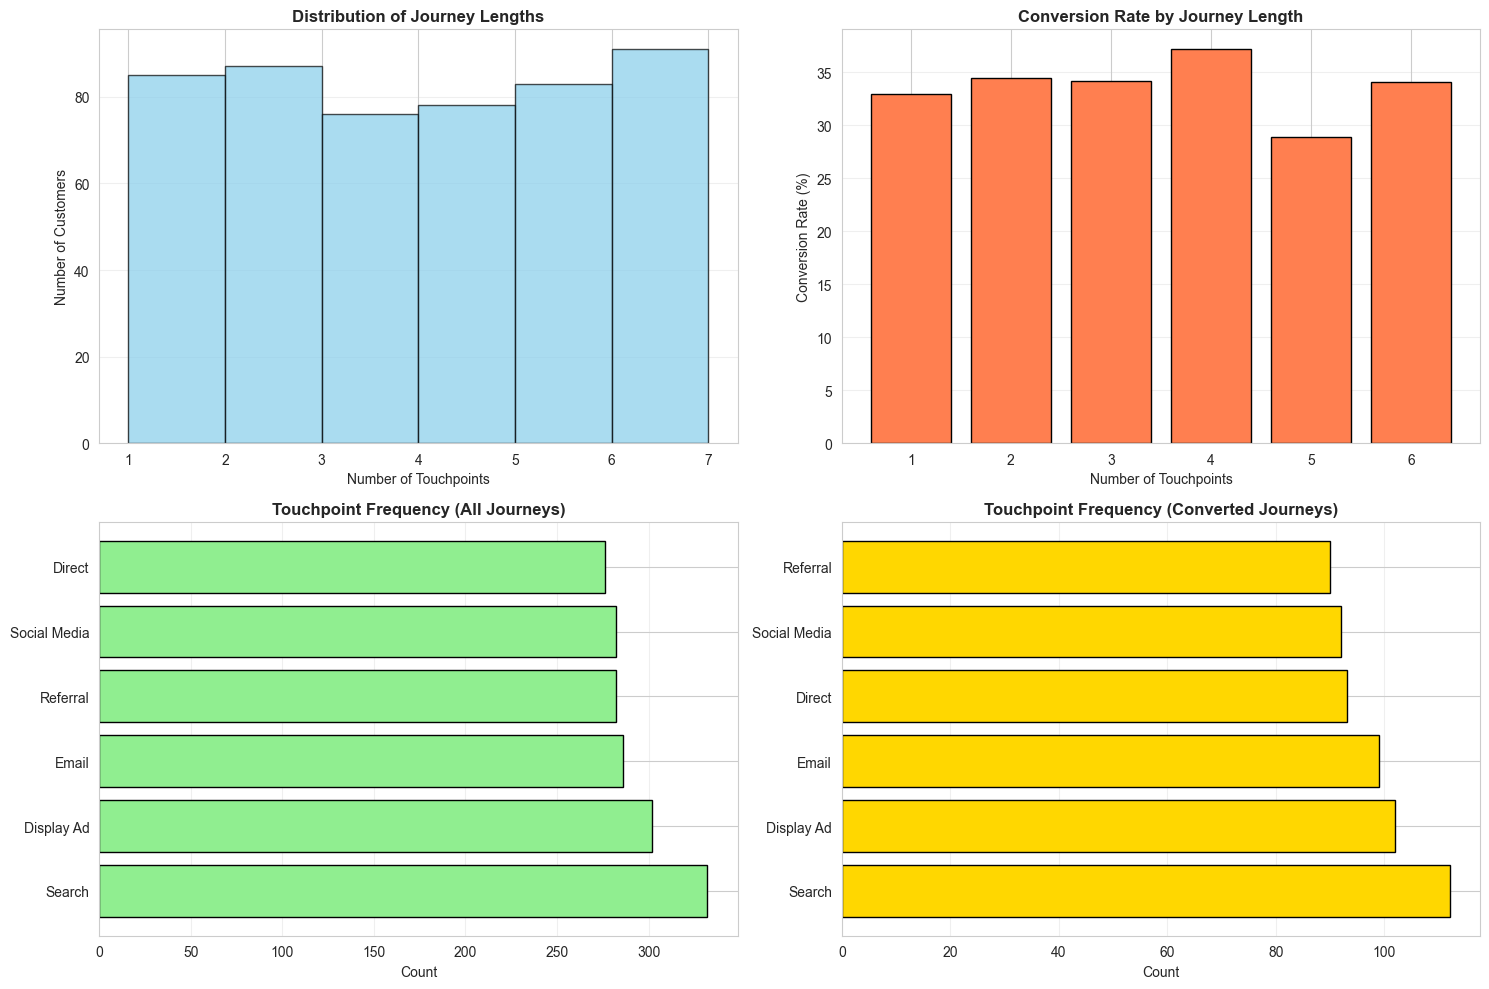

In [10]:
# Analyze journey characteristics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Distribution of Journey Lengths
axes[0, 0].hist(mta_data['n_touchpoints'], bins=range(1, 8), edgecolor='black', alpha=0.7, color='skyblue')
axes[0, 0].set_title('Distribution of Journey Lengths', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Number of Touchpoints')
axes[0, 0].set_ylabel('Number of Customers')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Plot 2: Conversion Rate by Journey Length
conversion_by_length = mta_data.groupby('n_touchpoints')['converted'].mean() * 100
axes[0, 1].bar(conversion_by_length.index, conversion_by_length.values, color='coral', edgecolor='black')
axes[0, 1].set_title('Conversion Rate by Journey Length', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Number of Touchpoints')
axes[0, 1].set_ylabel('Conversion Rate (%)')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Plot 3: Touchpoint Frequency (All Journeys)
all_touchpoints = [tp for journey in mta_data['touchpoints'] for tp in journey]
touchpoint_counts = pd.Series(all_touchpoints).value_counts()
axes[1, 0].barh(touchpoint_counts.index, touchpoint_counts.values, color='lightgreen', edgecolor='black')
axes[1, 0].set_title('Touchpoint Frequency (All Journeys)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Count')
axes[1, 0].grid(True, alpha=0.3, axis='x')

# Plot 4: Touchpoint Frequency (Converted Journeys Only)
converted_touchpoints = [tp for journey in mta_data[mta_data['converted']]['touchpoints'] for tp in journey]
converted_tp_counts = pd.Series(converted_touchpoints).value_counts()
axes[1, 1].barh(converted_tp_counts.index, converted_tp_counts.values, color='gold', edgecolor='black')
axes[1, 1].set_title('Touchpoint Frequency (Converted Journeys)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Count')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## Step 3: Implement Attribution Models

Now let's implement different attribution models to assign credit to touchpoints.

In [11]:
def last_touch_attribution(touchpoints, value):
    """Assigns 100% credit to the last touchpoint"""
    attribution = {tp: 0 for tp in touchpoint_channels}
    if len(touchpoints) > 0:
        attribution[touchpoints[-1]] = value
    return attribution

def first_touch_attribution(touchpoints, value):
    """Assigns 100% credit to the first touchpoint"""
    attribution = {tp: 0 for tp in touchpoint_channels}
    if len(touchpoints) > 0:
        attribution[touchpoints[0]] = value
    return attribution

def linear_attribution(touchpoints, value):
    """Assigns equal credit to all touchpoints"""
    attribution = {tp: 0 for tp in touchpoint_channels}
    if len(touchpoints) > 0:
        credit_per_tp = value / len(touchpoints)
        for tp in touchpoints:
            attribution[tp] += credit_per_tp
    return attribution

def time_decay_attribution(touchpoints, value, decay_rate=0.7):
    """Assigns more credit to recent touchpoints using exponential decay"""
    attribution = {tp: 0 for tp in touchpoint_channels}
    if len(touchpoints) > 0:
        n = len(touchpoints)
        # Calculate weights (more recent = higher weight)
        weights = [decay_rate ** (n - i - 1) for i in range(n)]
        total_weight = sum(weights)
        # Assign credit proportionally
        for i, tp in enumerate(touchpoints):
            attribution[tp] += value * (weights[i] / total_weight)
    return attribution

def position_based_attribution(touchpoints, value, first_last_weight=0.4):
    """Assigns 40% to first, 40% to last, 20% distributed among middle touchpoints"""
    attribution = {tp: 0 for tp in touchpoint_channels}
    if len(touchpoints) == 0:
        return attribution
    elif len(touchpoints) == 1:
        attribution[touchpoints[0]] = value
    elif len(touchpoints) == 2:
        attribution[touchpoints[0]] = value * 0.5
        attribution[touchpoints[1]] = value * 0.5
    else:
        # First and last get 40% each
        attribution[touchpoints[0]] += value * first_last_weight
        attribution[touchpoints[-1]] += value * first_last_weight
        # Middle touchpoints share remaining 20%
        middle_credit = value * (1 - 2 * first_last_weight) / (len(touchpoints) - 2)
        for tp in touchpoints[1:-1]:
            attribution[tp] += middle_credit
    return attribution

print("✓ Attribution models defined successfully!")
print("\nAvailable models:")
print("  1. Last-Touch Attribution")
print("  2. First-Touch Attribution")
print("  3. Linear Attribution")
print("  4. Time-Decay Attribution")
print("  5. Position-Based Attribution (U-Shaped)")

✓ Attribution models defined successfully!

Available models:
  1. Last-Touch Attribution
  2. First-Touch Attribution
  3. Linear Attribution
  4. Time-Decay Attribution
  5. Position-Based Attribution (U-Shaped)


## Step 4: Apply Attribution Models

Let's apply all attribution models to our customer journey data and compare results.

In [12]:
# Initialize attribution results
attribution_results = {
    'Last-Touch': {tp: 0 for tp in touchpoint_channels},
    'First-Touch': {tp: 0 for tp in touchpoint_channels},
    'Linear': {tp: 0 for tp in touchpoint_channels},
    'Time-Decay': {tp: 0 for tp in touchpoint_channels},
    'Position-Based': {tp: 0 for tp in touchpoint_channels}
}

# Apply each model to all converted journeys
for _, row in mta_data[mta_data['converted']].iterrows():
    touchpoints = row['touchpoints']
    value = row['conversion_value']
    
    # Apply each attribution model
    for model_name, model_func in [
        ('Last-Touch', last_touch_attribution),
        ('First-Touch', first_touch_attribution),
        ('Linear', linear_attribution),
        ('Time-Decay', time_decay_attribution),
        ('Position-Based', position_based_attribution)
    ]:
        attribution = model_func(touchpoints, value)
        for channel, credit in attribution.items():
            attribution_results[model_name][channel] += credit

# Convert to DataFrame for easier analysis
attribution_df = pd.DataFrame(attribution_results).round(2)

print("Attribution Results by Model ($):")
print("=" * 80)
print(attribution_df)
print("=" * 80)
print(f"\nTotal Revenue Attributed: ${attribution_df.sum().iloc[0]:.2f}")

Attribution Results by Model ($):
              Last-Touch  First-Touch   Linear  Time-Decay  Position-Based
Social Media     6844.74      5426.46  6062.71     6372.06         6006.99
Display Ad       8464.58      9555.17  8153.96     7893.70         8545.86
Email           10790.79      4700.98  7676.48     8419.94         7727.71
Search           7960.99      7931.65  8808.57     8712.86         8045.45
Direct           5967.73      8333.12  7014.45     6789.77         6799.85
Referral         3587.74      7669.21  5900.39     5428.25         5553.60

Total Revenue Attributed: $43616.57


## Step 5: Visualize Attribution Comparison

Let's visualize how different attribution models assign credit to each channel.

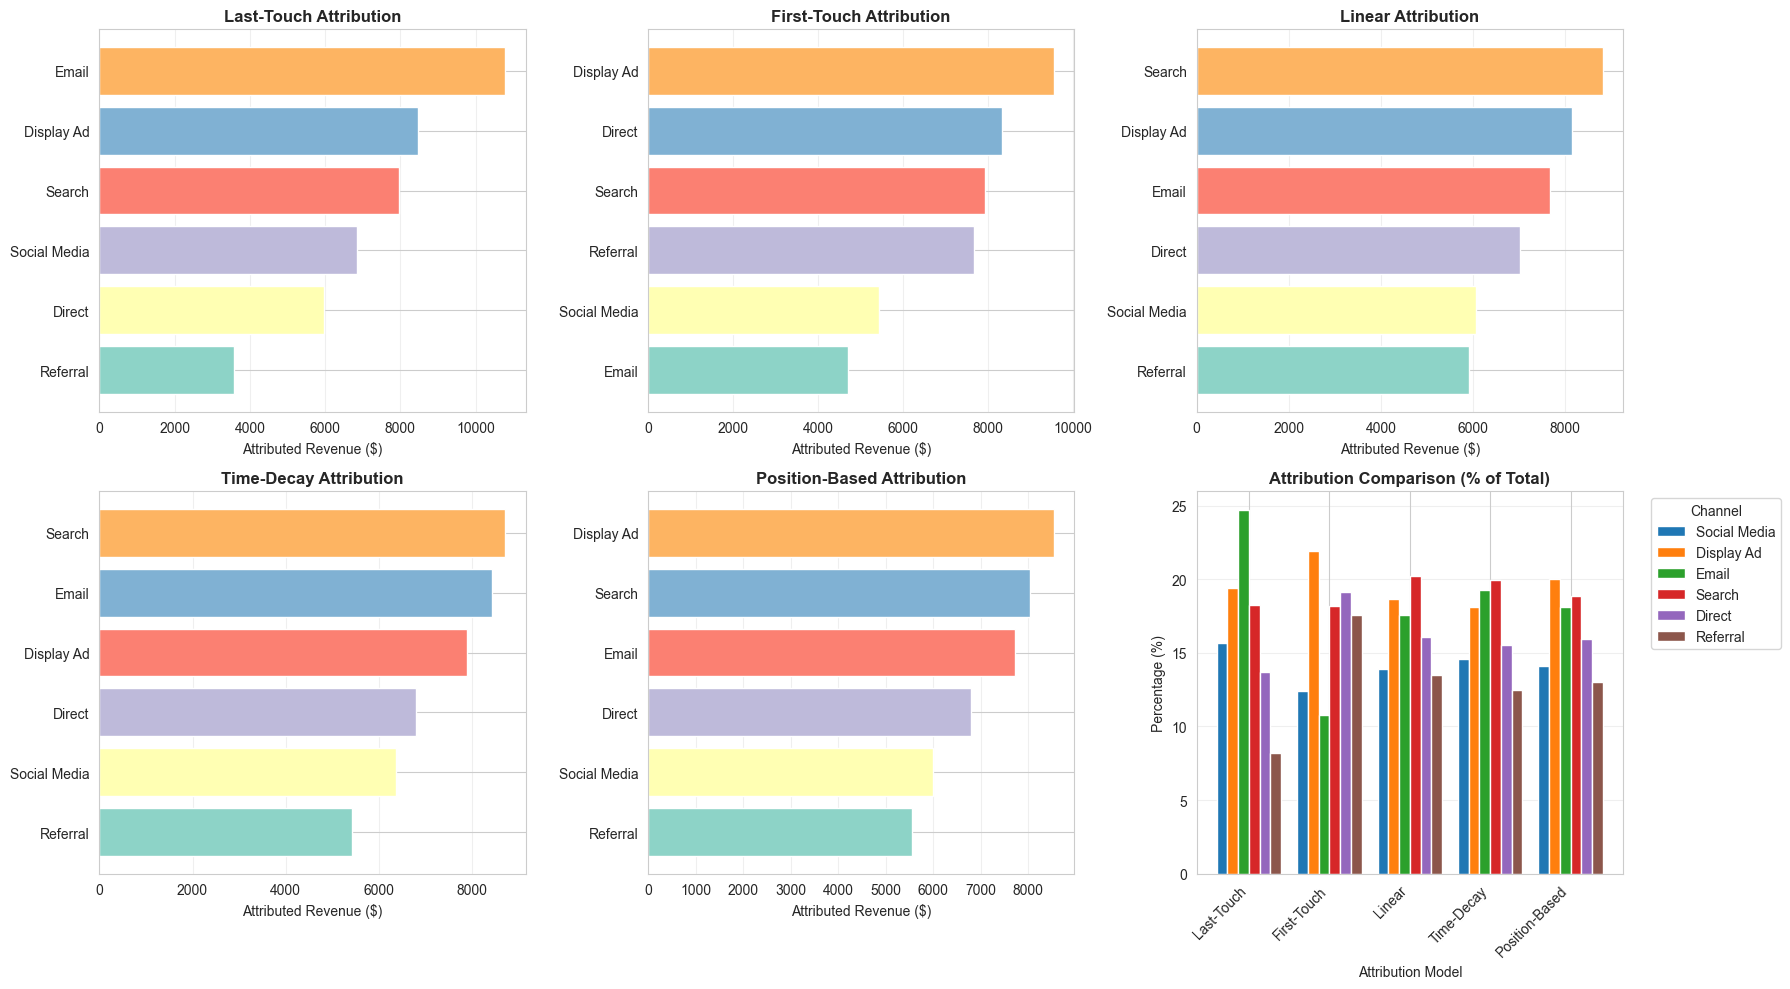

In [13]:
# Create comparison visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

models = ['Last-Touch', 'First-Touch', 'Linear', 'Time-Decay', 'Position-Based']
colors_palette = plt.cm.Set3(range(len(touchpoint_channels)))

for idx, model in enumerate(models):
    data = attribution_df[model].sort_values(ascending=True)
    axes[idx].barh(data.index, data.values, color=colors_palette)
    axes[idx].set_title(f'{model} Attribution', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Attributed Revenue ($)')
    axes[idx].grid(True, alpha=0.3, axis='x')

# Comparison plot in the last subplot
attribution_df_pct = attribution_df.div(attribution_df.sum(axis=0), axis=1) * 100
attribution_df_pct.T.plot(kind='bar', ax=axes[5], width=0.8)
axes[5].set_title('Attribution Comparison (% of Total)', fontsize=12, fontweight='bold')
axes[5].set_xlabel('Attribution Model')
axes[5].set_ylabel('Percentage (%)')
axes[5].legend(title='Channel', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[5].grid(True, alpha=0.3, axis='y')
axes[5].set_xticklabels(axes[5].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

## Step 6: Compare Attribution Models

Let's create a detailed comparison showing how each model differs in crediting channels.

In [14]:
# Calculate percentage attribution for each model
attribution_pct = attribution_df.div(attribution_df.sum(axis=0), axis=1) * 100

print("Attribution Percentage by Model:")
print("=" * 80)
print(attribution_pct.round(2))
print("=" * 80)

# Find the biggest differences between models
print("\n" + "=" * 80)
print("KEY INSIGHTS")
print("=" * 80)

for channel in touchpoint_channels:
    channel_values = attribution_pct.loc[channel]
    max_model = channel_values.idxmax()
    min_model = channel_values.idxmin()
    max_val = channel_values.max()
    min_val = channel_values.min()
    
    if max_val - min_val > 5:  # Only show significant differences
        print(f"\n{channel}:")
        print(f"  Highest credit: {max_val:.1f}% ({max_model})")
        print(f"  Lowest credit:  {min_val:.1f}% ({min_model})")
        print(f"  Difference:     {max_val - min_val:.1f} percentage points")

print("\n" + "=" * 80)

Attribution Percentage by Model:
              Last-Touch  First-Touch  Linear  Time-Decay  Position-Based
Social Media       15.69        12.44   13.90       14.61           14.07
Display Ad         19.41        21.91   18.69       18.10           20.02
Email              24.74        10.78   17.60       19.30           18.11
Search             18.25        18.18   20.20       19.98           18.85
Direct             13.68        19.11   16.08       15.57           15.93
Referral            8.23        17.58   13.53       12.45           13.01

KEY INSIGHTS

Email:
  Highest credit: 24.7% (Last-Touch)
  Lowest credit:  10.8% (First-Touch)
  Difference:     14.0 percentage points

Direct:
  Highest credit: 19.1% (First-Touch)
  Lowest credit:  13.7% (Last-Touch)
  Difference:     5.4 percentage points

Referral:
  Highest credit: 17.6% (First-Touch)
  Lowest credit:  8.2% (Last-Touch)
  Difference:     9.4 percentage points



## Step 7: Model Selection Guidance

Different attribution models are suitable for different business scenarios.

In [15]:
guidance = pd.DataFrame({
    'Model': ['Last-Touch', 'First-Touch', 'Linear', 'Time-Decay', 'Position-Based'],
    'Best For': [
        'Short sales cycles, direct response campaigns',
        'Brand awareness, top-of-funnel optimization',
        'Equal importance to all touchpoints',
        'Long sales cycles, recent interactions matter more',
        'Balanced view: awareness + conversion focus'
    ],
    'Pros': [
        'Simple, focuses on conversion drivers',
        'Values customer acquisition sources',
        'Fair, acknowledges all contributions',
        'Reflects recency bias in decisions',
        'Balanced, recognizes journey start & end'
    ],
    'Cons': [
        'Ignores earlier touchpoints',
        'Ignores conversion touchpoints',
        'May overvalue minor touchpoints',
        'Complex to explain to stakeholders',
        'Arbitrary weight distribution'
    ]
})

print("\n" + "=" * 100)
print("ATTRIBUTION MODEL SELECTION GUIDE")
print("=" * 100)
for idx, row in guidance.iterrows():
    print(f"\n{row['Model'].upper()}")
    print(f"  Best For: {row['Best For']}")
    print(f"  Pros:     {row['Pros']}")
    print(f"  Cons:     {row['Cons']}")
print("\n" + "=" * 100)


ATTRIBUTION MODEL SELECTION GUIDE

LAST-TOUCH
  Best For: Short sales cycles, direct response campaigns
  Pros:     Simple, focuses on conversion drivers
  Cons:     Ignores earlier touchpoints

FIRST-TOUCH
  Best For: Brand awareness, top-of-funnel optimization
  Pros:     Values customer acquisition sources
  Cons:     Ignores conversion touchpoints

LINEAR
  Best For: Equal importance to all touchpoints
  Pros:     Fair, acknowledges all contributions
  Cons:     May overvalue minor touchpoints

TIME-DECAY
  Best For: Long sales cycles, recent interactions matter more
  Pros:     Reflects recency bias in decisions
  Cons:     Complex to explain to stakeholders

POSITION-BASED
  Best For: Balanced view: awareness + conversion focus
  Pros:     Balanced, recognizes journey start & end
  Cons:     Arbitrary weight distribution



---

# Summary: MMM vs MTA

## Key Differences

| Aspect | Marketing Mix Modeling (MMM) | Multi-Touch Attribution (MTA) |
|--------|------------------------------|-------------------------------|
| **Approach** | Top-down, aggregate | Bottom-up, individual |
| **Data Level** | Weekly/monthly totals | User-level journeys |
| **Channels** | All (online + offline) | Primarily digital |
| **Privacy** | Privacy-friendly | Requires user tracking |
| **Time Horizon** | Long-term trends | Short-term optimization |
| **Best For** | Strategic planning, budget allocation | Tactical optimization, journey analysis |

## When to Use Each

**Use MMM when:**
- You have significant offline marketing spend (TV, radio, print)
- You need to understand long-term trends and seasonality
- Privacy regulations limit user-level tracking
- You're doing strategic budget planning

**Use MTA when:**
- Your marketing is primarily digital
- You need granular, touchpoint-level insights
- You want to optimize specific customer journeys
- You have robust tracking infrastructure

**Use Both when:**
- You have a mix of online and offline channels
- You need both strategic and tactical insights
- You want to validate findings across methodologies

---

## 🎓 Learning Objectives Achieved

By completing this notebook, you have:

1. ✅ Understood the fundamentals of Marketing Mix Modeling (MMM)
2. ✅ Built a regression-based MMM model to quantify channel impact
3. ✅ Calculated ROI and sales contribution by marketing channel
4. ✅ Learned about Multi-Touch Attribution (MTA) concepts
5. ✅ Implemented five different attribution models
6. ✅ Compared how different models assign credit to touchpoints
7. ✅ Understood when to use MMM vs MTA in practice

---
